# 1. Visualizing raw data

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd 
import numpy as np  
import seaborn as sns  
import matplotlib
import matplotlib.pyplot as plt 
import matplotlib.dates as md

import sys
import os
sys.path.append(os.path.abspath('../'))

import Airpeak

In [3]:
df = pd.read_csv('data/sample_classroom_CO2_data.csv')
df['Time'] = pd.to_datetime(df['Time'])
df

,Time,CO2_Concentration_ppm
0,2024-09-03 01:00:08,395
1,2024-09-03 01:01:21,389
2,2024-09-03 01:01:58,390
3,2024-09-03 01:02:44,393
4,2024-09-03 01:04:12,394
...,...,...
5994,2024-09-07 04:56:18,435
5995,2024-09-07 04:57:11,432
5996,2024-09-07 04:58:27,435
5997,2024-09-07 04:59:08,441


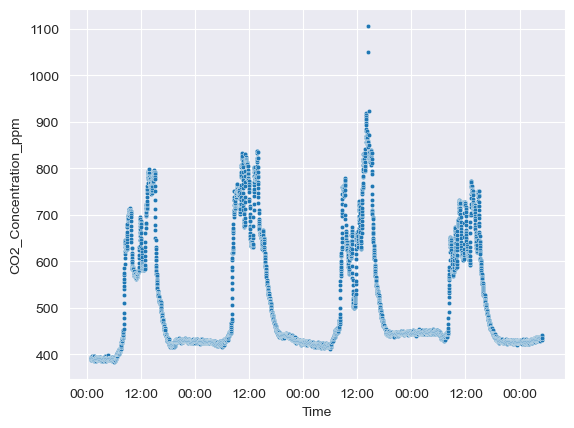

In [4]:
ax = sns.scatterplot(data=df,x='Time',y='CO2_Concentration_ppm',s=10)
myFmt = md.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(myFmt)

# 2. Preprocessing

## 2.1 outlier removal and smoothing

for noisy data such as PM reading from low-cost optical particle counters

In [5]:
df_or = Airpeak.outlier_removal(df,'CO2_Concentration_ppm',10)
df_or 

,Time,CO2_Concentration_ppm
0,2024-09-03 01:00:08,395
1,2024-09-03 01:01:21,389
2,2024-09-03 01:01:58,390
3,2024-09-03 01:02:44,393
4,2024-09-03 01:04:12,394
...,...,...
5994,2024-09-07 04:56:18,435
5995,2024-09-07 04:57:11,432
5996,2024-09-07 04:58:27,435
5997,2024-09-07 04:59:08,441


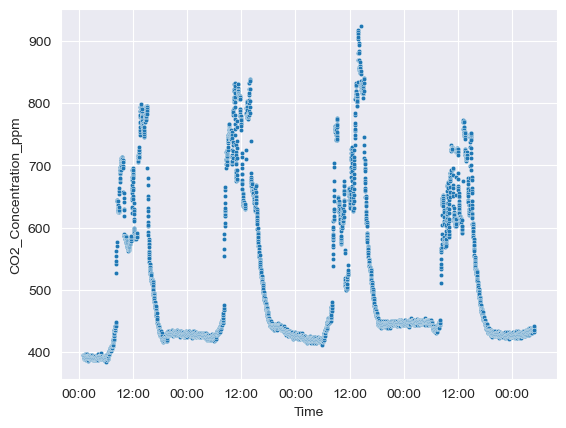

In [6]:
ax = sns.scatterplot(data=df_or,x='Time',y='CO2_Concentration_ppm',s=10)
myFmt = md.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(myFmt)
#note the two highest value of >1000 ppm is considered outlier and removed

In [7]:
df_sm = Airpeak.smoothing(df_or,'CO2_Concentration_ppm',5,2)
df_sm

,Time,CO2_Concentration_ppm
0,2024-09-03 01:00:08,394.085714
1,2024-09-03 01:01:21,390.857143
2,2024-09-03 01:01:58,389.914286
3,2024-09-03 01:02:44,392.485714
4,2024-09-03 01:04:12,394.428571
...,...,...
5994,2024-09-07 04:56:18,435.514286
5995,2024-09-07 04:57:11,432.600000
5996,2024-09-07 04:58:27,436.028571
5997,2024-09-07 04:59:08,436.714286


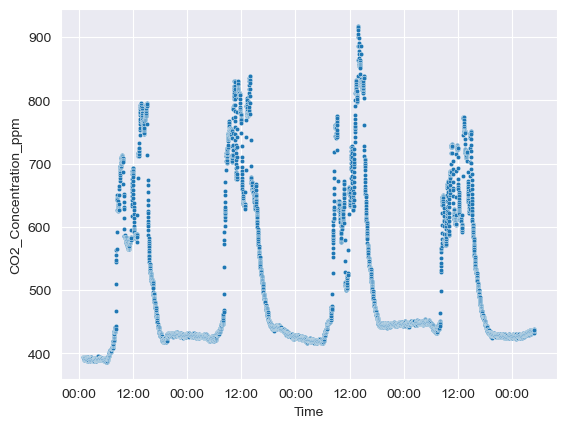

In [8]:
ax = sns.scatterplot(data=df_sm,x='Time',y='CO2_Concentration_ppm',s=10)
myFmt = md.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(myFmt)
#note the spikes are smoothed
#but we will continue with df_or

# 2.2 baseline recognition

not necessary if outdoor data available

In [9]:
df_bd = Airpeak.baseline_detection(df_sm,'CO2_Concentration_ppm',base_lambda = 1e7, base_p =0.0001)
#note that I have to adjust lambda and p
#try different values and see the results
df_bd

,Time,CO2_Concentration_ppm,baseline
0,2024-09-03 01:00:08,394.085714,379.750487
1,2024-09-03 01:01:21,390.857143,379.765200
2,2024-09-03 01:01:58,389.914286,379.779995
3,2024-09-03 01:02:44,392.485714,379.794873
4,2024-09-03 01:04:12,394.428571,379.809834
...,...,...,...
5994,2024-09-07 04:56:18,435.514286,424.337111
5995,2024-09-07 04:57:11,432.600000,424.343637
5996,2024-09-07 04:58:27,436.028571,424.350186
5997,2024-09-07 04:59:08,436.714286,424.356759


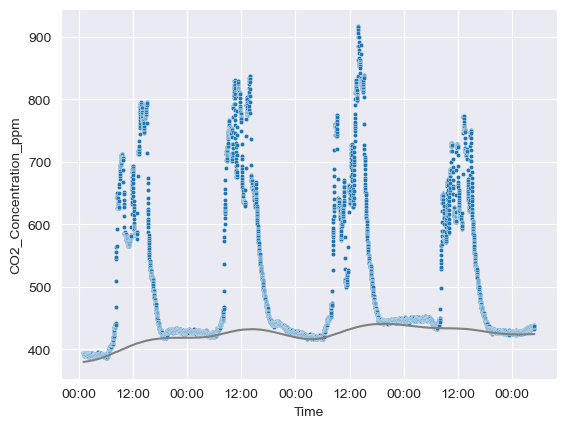

In [10]:
ax = sns.scatterplot(data=df_bd,x='Time',y='CO2_Concentration_ppm',s=10)
sns.lineplot(data=df_bd,x='Time',y='baseline',ax=ax,color='gray')
myFmt = md.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(myFmt)

# Generating data features for clustering

In [11]:
df_fg = Airpeak.feature_generation(df_bd,'CO2_Concentration_ppm','Time',diff_ma_window = 5, diff_rhl_window = 5)

# I am using droping NA as a lazy way to handle NAs generated by gradient calculation and log function
df_fg = df_fg.dropna(subset=['diff','diff_ma','diff_gd','diff_gd_ln','diff_gd_sign','diff_gd_abs','diff_rhl'])

df_fg

,Time,CO2_Concentration_ppm,baseline,min_diff,diff,diff_ma,diff_gd,diff_gd_ln,diff_gd_sign,diff_gd_abs,diff_rhl
1,2024-09-03 01:01:21,390.857143,379.765200,1.216667,11.091943,12.063075,0.171991,0.014383,1,0.171991,0.227962
2,2024-09-03 01:01:58,389.914286,379.779995,0.616667,10.134290,12.574208,0.828863,0.067295,1,0.828863,0.000000
3,2024-09-03 01:02:44,392.485714,379.794873,0.766667,12.690841,12.605044,0.040221,0.003195,1,0.040221,0.570093
4,2024-09-03 01:04:12,394.428571,379.809834,1.466667,14.618737,13.172940,0.387202,0.030046,1,0.387202,1.000000
5,2024-09-03 01:04:37,394.314286,379.824878,0.416667,14.489408,13.569325,0.951324,0.071153,1,0.951324,0.948320
...,...,...,...,...,...,...,...,...,...,...,...
5994,2024-09-07 04:56:18,435.514286,424.337111,1.116667,11.177174,11.634294,0.142578,0.012340,1,0.142578,0.497568
5995,2024-09-07 04:57:11,432.600000,424.343637,0.883333,8.256363,11.519197,-0.130299,-0.011255,0,0.130299,0.000000
5996,2024-09-07 04:58:27,436.028571,424.350186,1.266667,11.678385,11.215505,-0.239757,-0.021093,0,0.239757,0.786362
5997,2024-09-07 04:59:08,436.714286,424.356759,0.683333,12.357527,11.225087,0.014023,0.001250,1,0.014023,0.942426


# 3. Extracting decays

## 3.1 Recognize elevations

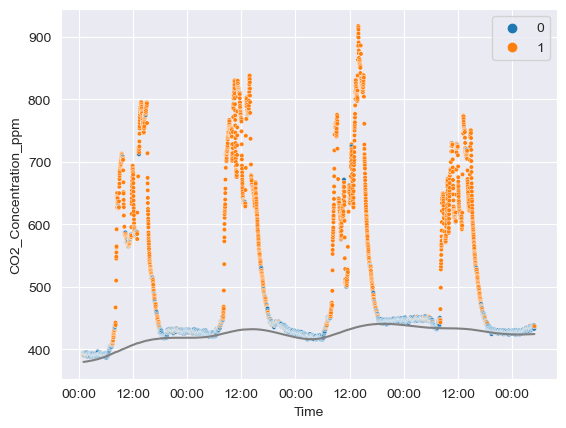

In [12]:
df_ele = Airpeak.k_means_ele(df_fg)

ax = sns.scatterplot(data=df_ele,x='Time',y='CO2_Concentration_ppm',hue='elevated',s=10)
sns.lineplot(data=df_ele,x='Time',y='baseline',ax=ax,color='gray')

myFmt = md.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(myFmt)

## 3.2 Differentiating build-ups and decays (or plateaus if reaches steady state)

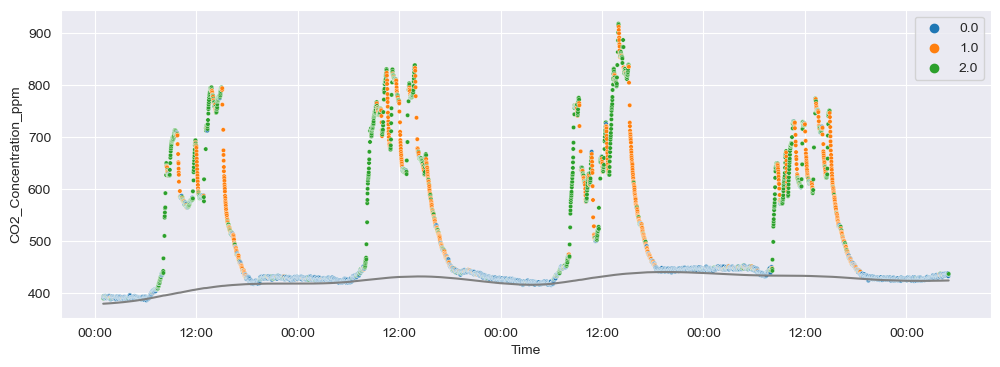

In [13]:
df_diff = Airpeak.k_means_diff(df_ele, 'Time')

plt.figure(figsize=(12,4))
palette = sns.color_palette("tab10")[0:3]
ax = sns.scatterplot(data=df_diff,x='Time',y='CO2_Concentration_ppm',hue='status_label',s=10,palette=palette)
sns.lineplot(data=df_diff,x='Time',y='baseline',ax=ax,color='gray')

myFmt = md.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(myFmt)

#separation looks reasonable to me @HERE

# 3.3 Extracting individual decay periods

In [17]:
df_decay = Airpeak.dbscan(df_diff, 'Time', eps=0.05, ms=5)
# please do play with eps and ms to understand their impact
# a larger eps tend to connect multiple decay periods as a larger one 
# a larger ms excludes very short decay periods 

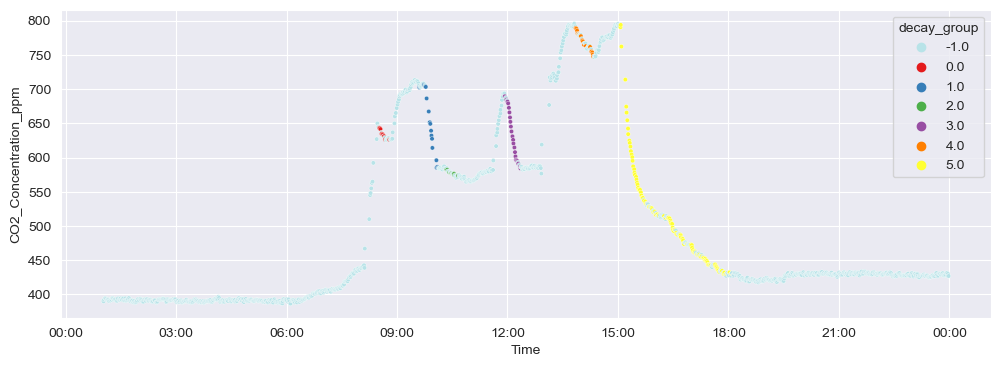

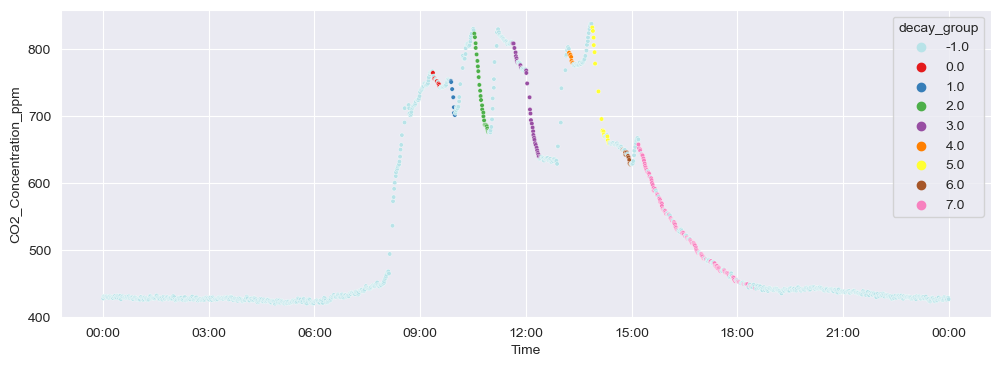

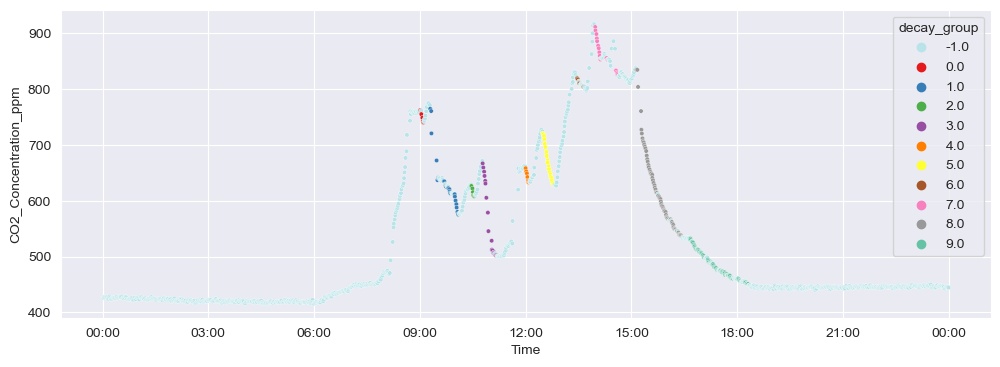

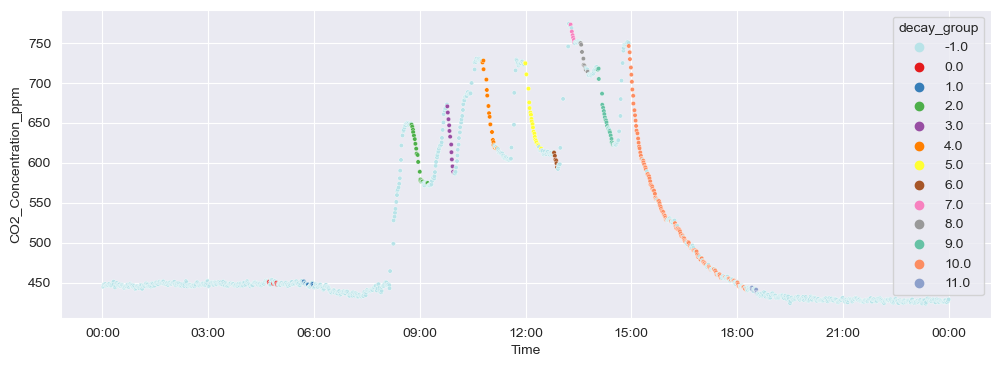

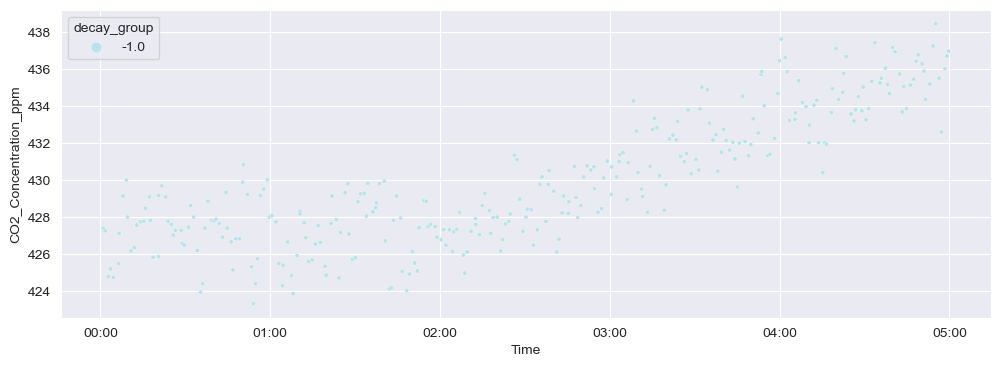

In [18]:
palette=[(0.72,0.89,0.91)]+list(sns.color_palette('Set1'))+list(sns.color_palette('Set2'))+list(sns.color_palette('Set1'))+list(sns.color_palette('Set2'))

date_list = df_decay['Date'].unique()
for date in date_list:
    plt.figure(figsize=(12,4))
    df_decay_singleday = df_decay.loc[df_decay['Date']==date]
    palette_num = len(df_decay_singleday['decay_group'].unique())
    ax = sns.scatterplot(data=df_decay_singleday,x='Time',y='CO2_Concentration_ppm',hue='decay_group',s=10,palette=palette[0:palette_num])
    myFmt = md.DateFormatter('%H:%M')
    ax.xaxis.set_major_formatter(myFmt)

# 4. Mass balance

In [19]:
#I am running regression by date to have more flexibility
#when there's multiple locations,
#consider adding a loop for location and remember to add "location" to regression result

date_list = df_decay['Date'].unique()
decay_rate_result = pd.DataFrame()
for date in date_list:
    df_working = df_decay.loc[df_decay['Date']==date]
    decay_rate = Airpeak.decay_regress(df_working, 'CO2_Concentration_ppm','Time')
    decay_rate_result = pd.concat([decay_rate_result,decay_rate])
    
decay_rate_result

,pollutant,time,decay_start,decay_end,decay_rate,r2,ste,num_of_point,base_value,median_ele,max_diff,group,method
0,CO2_Concentration_ppm,2024-09-03 08:36:21,2024-09-03 08:31:22,2024-09-03 08:47:32,0.317268,0.852530,0.011850,9,396.173260,237.621419,-17.257143,0.0,decay
1,CO2_Concentration_ppm,2024-09-03 09:55:29,2024-09-03 09:36:31,2024-09-03 10:07:14,1.264997,0.918851,0.055675,16,399.844223,243.476716,-116.828571,1.0,decay
2,CO2_Concentration_ppm,2024-09-03 10:32:52,2024-09-03 10:20:11,2024-09-03 10:39:30,0.190424,0.940884,0.006097,7,401.849361,174.700663,-9.485714,2.0,decay
3,CO2_Concentration_ppm,2024-09-03 12:09:09,2024-09-03 11:55:41,2024-09-03 12:21:04,1.332272,0.968536,0.029092,22,406.832278,220.937297,-105.342857,3.0,decay
4,CO2_Concentration_ppm,2024-09-03 14:04:40,2024-09-03 13:51:08,2024-09-03 14:19:38,0.225872,0.969567,0.007291,15,411.413747,357.589364,-41.714286,4.0,decay
5,CO2_Concentration_ppm,2024-09-03 16:29:35,2024-09-03 15:04:08,2024-09-03 18:04:52,0.937398,0.964251,0.160639,111,413.899813,81.713086,-359.857143,5.0,decay
0,CO2_Concentration_ppm,2024-09-04 09:31:04,2024-09-04 09:21:42,2024-09-04 09:33:03,0.282116,0.946819,0.005427,7,427.444021,324.456642,-20.257143,0.0,decay
1,CO2_Concentration_ppm,2024-09-04 09:57:26,2024-09-04 09:52:26,2024-09-04 09:58:59,1.656748,0.965106,0.014650,7,428.338808,299.774983,-50.885714,1.0,decay
2,CO2_Concentration_ppm,2024-09-04 10:43:36,2024-09-04 10:32:06,2024-09-04 10:55:39,1.265019,0.971484,0.027194,25,429.325692,294.342361,-147.000000,2.0,decay
3,CO2_Concentration_ppm,2024-09-04 12:08:35,2024-09-04 11:37:40,2024-09-04 12:24:32,0.827372,0.936295,0.054931,31,430.768451,272.666293,-169.228571,3.0,decay


In [20]:
#Results contain short and less consistent decay periods

<AxesSubplot:xlabel='time', ylabel='decay_rate'>

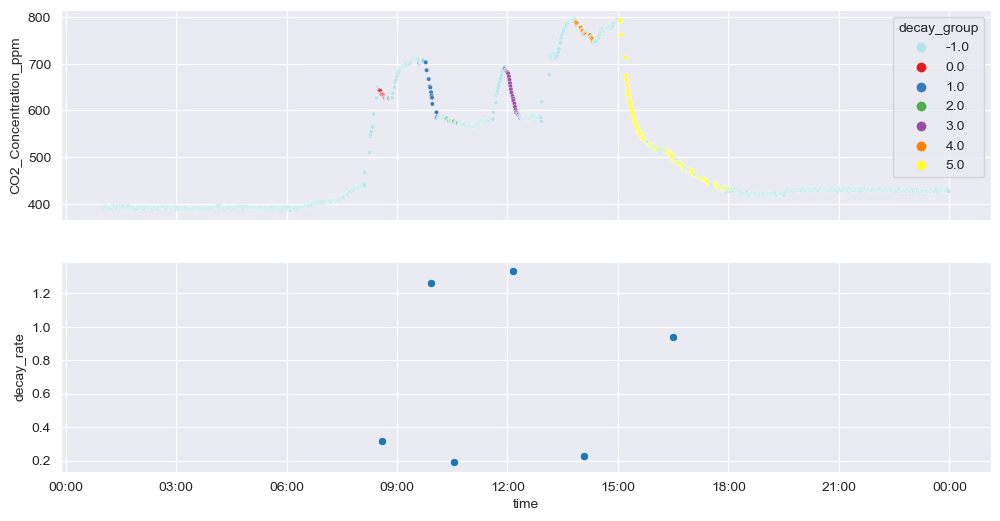

In [21]:
# An example for visualization
f, (ax1, ax2) = plt.subplots(2, 1, figsize = (12,6),sharex=True)

palette=[(0.72,0.89,0.91)]+list(sns.color_palette('Set1'))+list(sns.color_palette('Set2'))+list(sns.color_palette('Set1'))+list(sns.color_palette('Set2'))

date = date_list[0]
df_decay_singleday = df_decay.loc[df_decay['Date']==date]

decay_rate_result['Date'] = decay_rate_result['time'].dt.date
df_result_singleday = decay_rate_result.loc[decay_rate_result['Date']==date]

palette_num = len(df_decay_singleday['decay_group'].unique())
sns.scatterplot(data=df_decay_singleday,x='Time',y='CO2_Concentration_ppm',hue='decay_group',s=10,ax=ax1,palette=palette[0:palette_num])
myFmt = md.DateFormatter('%H:%M')
ax1.xaxis.set_major_formatter(myFmt)

sns.scatterplot(data=df_result_singleday, x='time',y='decay_rate',ax=ax2)

In [22]:
#We could run result filtration to select longer and more consistent ones for further analysis
decay_rate_result_selected = decay_rate_result.loc[(decay_rate_result['num_of_point']>=10)&(decay_rate_result['r2']>=0.9)]
decay_rate_result_selected

,pollutant,time,decay_start,decay_end,decay_rate,r2,ste,num_of_point,base_value,median_ele,max_diff,group,method,Date
1,CO2_Concentration_ppm,2024-09-03 09:55:29,2024-09-03 09:36:31,2024-09-03 10:07:14,1.264997,0.918851,0.055675,16,399.844223,243.476716,-116.828571,1.0,decay,2024-09-03
3,CO2_Concentration_ppm,2024-09-03 12:09:09,2024-09-03 11:55:41,2024-09-03 12:21:04,1.332272,0.968536,0.029092,22,406.832278,220.937297,-105.342857,3.0,decay,2024-09-03
4,CO2_Concentration_ppm,2024-09-03 14:04:40,2024-09-03 13:51:08,2024-09-03 14:19:38,0.225872,0.969567,0.007291,15,411.413747,357.589364,-41.714286,4.0,decay,2024-09-03
5,CO2_Concentration_ppm,2024-09-03 16:29:35,2024-09-03 15:04:08,2024-09-03 18:04:52,0.937398,0.964251,0.160639,111,413.899813,81.713086,-359.857143,5.0,decay,2024-09-03
2,CO2_Concentration_ppm,2024-09-04 10:43:36,2024-09-04 10:32:06,2024-09-04 10:55:39,1.265019,0.971484,0.027194,25,429.325692,294.342361,-147.000000,2.0,decay,2024-09-04
3,CO2_Concentration_ppm,2024-09-04 12:08:35,2024-09-04 11:37:40,2024-09-04 12:24:32,0.827372,0.936295,0.054931,31,430.768451,272.666293,-169.228571,3.0,decay,2024-09-04
5,CO2_Concentration_ppm,2024-09-04 14:10:19,2024-09-04 13:53:01,2024-09-04 14:21:40,1.275073,0.942991,0.055093,17,432.111353,246.323434,-172.971429,5.0,decay,2024-09-04
7,CO2_Concentration_ppm,2024-09-04 16:35:37,2024-09-04 15:11:34,2024-09-04 18:30:01,0.773797,0.990310,0.071310,123,431.998053,86.448331,-215.000000,7.0,decay,2024-09-04
3,CO2_Concentration_ppm,2024-09-05 11:02:15,2024-09-05 10:47:01,2024-09-05 11:10:54,3.466353,0.959477,0.100901,18,429.227815,107.497526,-164.285714,3.0,decay,2024-09-05
5,CO2_Concentration_ppm,2024-09-05 12:39:25,2024-09-05 12:29:03,2024-09-05 12:47:53,1.377818,0.987885,0.015212,20,432.981385,232.093203,-90.800000,5.0,decay,2024-09-05


<AxesSubplot:xlabel='time', ylabel='decay_rate'>

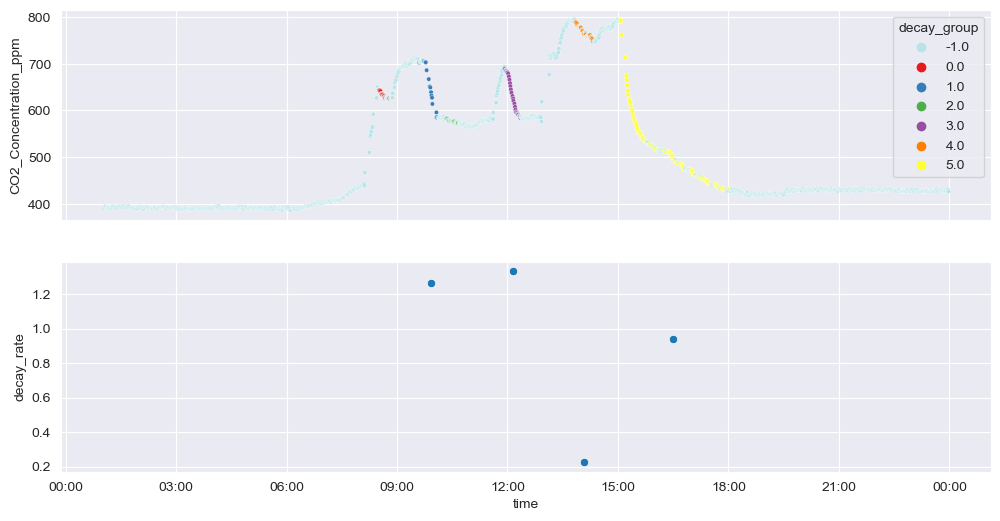

In [23]:
# An example for visualization
f, (ax1, ax2) = plt.subplots(2, 1, figsize = (12,6),sharex=True)

palette=[(0.72,0.89,0.91)]+list(sns.color_palette('Set1'))+list(sns.color_palette('Set2'))+list(sns.color_palette('Set1'))+list(sns.color_palette('Set2'))

date = date_list[0]
df_decay_singleday = df_decay.loc[df_decay['Date']==date]

decay_rate_result_selected['Date'] = decay_rate_result_selected['time'].dt.date
df_result_selected_singleday = decay_rate_result_selected.loc[decay_rate_result_selected['Date']==date]

palette_num = len(df_decay_singleday['decay_group'].unique())
sns.scatterplot(data=df_decay_singleday,x='Time',y='CO2_Concentration_ppm',hue='decay_group',s=10,ax=ax1,palette=palette[0:palette_num])
myFmt = md.DateFormatter('%H:%M')
ax1.xaxis.set_major_formatter(myFmt)

sns.scatterplot(data=df_result_selected_singleday, x='time',y='decay_rate',ax=ax2)

In [23]:
# End of example